In [1]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#
#       http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#!pip install PyWavelets

In [3]:
from typing import Tuple, Union, Optional, List
import pywt
import torch
import torch.nn as nn
from torch.optim.adamw import AdamW
from torch.optim.sgd import SGD
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

T = torch.Tensor
TN = Optional[T]
TS = Union[Tuple[T, ...], List[T]]

device = torch.device('cuda:0')


/home/efe/miniconda3/envs/wavelet/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Delta Denoising Score: zero-shot image editing

In [4]:
def load_512(image_path: str, left=0, right=0, top=0, bottom=0):
    image = np.array(Image.open(image_path))[:, :, :3]    
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image


@torch.no_grad()
def get_text_embeddings(pipe: StableDiffusionPipeline, text: str) -> T:
    tokens = pipe.tokenizer([text], padding="max_length", max_length=77, truncation=True,
                                   return_tensors="pt", return_overflowing_tokens=True).input_ids.to(device)
    return pipe.text_encoder(tokens).last_hidden_state.detach()

@torch.no_grad()
def denormalize(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image * 255).astype(np.uint8)
    return image[0]


@torch.no_grad()
def decode(latent: T, pipe: StableDiffusionPipeline, im_cat: TN = None):
    image = pipeline.vae.decode((1 / 0.18215) * latent, return_dict=False)[0]
    image = denormalize(image)
    if im_cat is not None:
        image = np.concatenate((im_cat, image), axis=1)
    return Image.fromarray(image)


In [5]:

def init_pipe(device, dtype, unet, scheduler) -> Tuple[UNet2DConditionModel, T, T]:

    with torch.inference_mode():
        alphas = torch.sqrt(scheduler.alphas_cumprod).to(device, dtype=dtype)
        sigmas = torch.sqrt(1 - scheduler.alphas_cumprod).to(device, dtype=dtype)
    for p in unet.parameters():
        p.requires_grad = False
    return unet, alphas, sigmas


class DDSLoss:

    def noise_input(self, z, eps=None, timestep: Optional[int] = None):
        if timestep is None:
            b = z.shape[0]
            timestep = torch.randint(
                low=self.t_min,
                high=min(self.t_max, 1000) - 1,  # Avoid the highest timestep.
                size=(b,),
                device=z.device, dtype=torch.long)
        if eps is None:
            eps = torch.randn_like(z)
        alpha_t = self.alphas[timestep, None, None, None]
        sigma_t = self.sigmas[timestep, None, None, None]
        z_t = alpha_t * z + sigma_t * eps
        return z_t, eps, timestep, alpha_t, sigma_t

    def get_eps_prediction(self, z_t: T, timestep: T, text_embeddings: T, alpha_t: T, sigma_t: T, get_raw=False,
                           guidance_scale=7.5):

        latent_input = torch.cat([z_t] * 2)
        timestep = torch.cat([timestep] * 2)
        embedd = text_embeddings.permute(1, 0, 2, 3).reshape(-1, *text_embeddings.shape[2:])
        with torch.autocast(device_type="cuda", dtype=torch.float16):
            e_t = self.unet(latent_input, timestep, embedd).sample
            if self.prediction_type == 'v_prediction':
                e_t = torch.cat([alpha_t] * 2) * e_t + torch.cat([sigma_t] * 2) * latent_input
            e_t_uncond, e_t = e_t.chunk(2)
            if get_raw:
                return e_t_uncond, e_t
            e_t = e_t_uncond + guidance_scale * (e_t - e_t_uncond)
            assert torch.isfinite(e_t).all()
        if get_raw:
            return e_t
        pred_z0 = (z_t - sigma_t * e_t) / alpha_t
        return e_t, pred_z0

    def get_sds_loss(self, z: T, text_embeddings: T, eps: TN = None, mask=None, t=None,
                 timestep: Optional[int] = None, guidance_scale=7.5) -> TS:
        with torch.inference_mode():
            z_t, eps, timestep, alpha_t, sigma_t = self.noise_input(z, eps=eps, timestep=timestep)
            e_t, _ = self.get_eps_prediction(z_t, timestep, text_embeddings, alpha_t, sigma_t,
                                             guidance_scale=guidance_scale)
            grad_z = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (e_t - eps)
            assert torch.isfinite(grad_z).all()
            grad_z = torch.nan_to_num(grad_z.detach(), 0.0, 0.0, 0.0)
            if mask is not None:
                grad_z = grad_z * mask
            log_loss = (grad_z ** 2).mean()
        sds_loss = grad_z.clone() * z
        del grad_z
        return sds_loss.sum() / (z.shape[2] * z.shape[3]), log_loss


    def get_dds_loss(self, z_source: T, z_target: T, text_emb_source: T, text_emb_target: T,
                            eps=None, reduction='mean', symmetric: bool = False, calibration_grad=None, timestep: Optional[int] = None,
                      guidance_scale=7.5, raw_log=False) -> TS:
        with torch.inference_mode():
            z_t_source, eps, timestep, alpha_t, sigma_t = self.noise_input(z_source, eps, timestep)
            z_t_target, _, _, _, _ = self.noise_input(z_target, eps, timestep)
            eps_pred, _ = self.get_eps_prediction(torch.cat((z_t_source, z_t_target)),
                                                  torch.cat((timestep, timestep)),
                                                  torch.cat((text_emb_source, text_emb_target)),
                                                  torch.cat((alpha_t, alpha_t)),
                                                  torch.cat((sigma_t, sigma_t)),
                                                  guidance_scale=guidance_scale)
            eps_pred_source, eps_pred_target = eps_pred.chunk(2)
            grad = (alpha_t ** self.alpha_exp) * (sigma_t ** self.sigma_exp) * (eps_pred_target - eps_pred_source)
            if calibration_grad is not None:
                if calibration_grad.dim() == 4:
                    grad = grad - calibration_grad
                else:
                    grad = grad - calibration_grad[timestep - self.t_min]
            if raw_log:
                log_loss = eps.detach().cpu(), eps_pred_target.detach().cpu(), eps_pred_source.detach().cpu()
            else:
                log_loss = (grad ** 2).mean()
        loss = z_target * grad.clone()
        if symmetric:
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
            loss_symm = self.rescale * z_source * (-grad.clone())
            loss += loss_symm.sum() / (z_target.shape[2] * z_target.shape[3])
        elif reduction == 'mean':
            loss = loss.sum() / (z_target.shape[2] * z_target.shape[3])
        return loss, log_loss

    def __init__(self, device, pipe: StableDiffusionPipeline, dtype=torch.float32):
        self.t_min = 50
        self.t_max = 950
        self.alpha_exp = 0
        self.sigma_exp = 0
        self.dtype = dtype
        self.unet, self.alphas, self.sigmas = init_pipe(device, dtype, pipe.unet, pipe.scheduler)
        self.prediction_type = pipe.scheduler.prediction_type





In [6]:
model_id  =  ["runwayml/stable-diffusion-v1-5", "stabilityai/stable-diffusion-2-1"][0]
pipeline = StableDiffusionPipeline.from_pretrained(model_id,).to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 10.91it/s]


In [48]:
import torch
import torch.nn.functional as F

def low_pass_filter_grad_wavelet_torch(grad, level=1):
    """
    Efficiently applies a low-pass filter to the gradient using a wavelet-inspired approach.
    This implementation uses repeated average pooling to approximate the low-frequency
    component (akin to the Haar wavelet's approximation coefficients) and then upsamples
    back to the original size.
    
    Args:
        grad (torch.Tensor): Gradient tensor of shape [B, C, H, W].
        level (int): The number of pooling levels to apply.
        
    Returns:
        torch.Tensor: The gradient after low-pass filtering.
    """
    B, C, H, W = grad.shape
    x = grad
    # Repeated average pooling to extract low-frequency content.
    for _ in range(level):
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
    # Scale the pooled result: for Haar wavelet, multiply by 2^level.
    x = x * (2 ** level)
    # Upsample back to original dimensions.
    x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=False)
    return x

def image_optimization(pipe: StableDiffusionPipeline, image: np.ndarray, text_source: str, text_target: str, num_iters=200, use_dds=True) -> None:
    dds_loss = DDSLoss(device, pipe)
    image_source = torch.from_numpy(image).float().permute(2, 0, 1) / 127.5 - 1
    image_source = image_source.unsqueeze(0).to(device)
    with torch.no_grad():
        z_source = pipeline.vae.encode(image_source)['latent_dist'].mean * 0.18215
        image_target = image_source.clone()
        embedding_null = get_text_embeddings(pipeline, "")
        embedding_text = get_text_embeddings(pipeline, text_source)
        embedding_text_target = get_text_embeddings(pipeline, text_target)
        embedding_source = torch.stack([embedding_null, embedding_text], dim=1)
        embedding_target = torch.stack([embedding_null, embedding_text_target], dim=1)

    guidance_scale = 8
    image_target.requires_grad = True
    use_dds_loss = True

    z_taregt = z_source.clone()
    z_taregt.requires_grad = True
    optimizer = SGD(params=[z_taregt], lr=1e-1)

    # Within your optimization loop:
    for i in range(num_iters):
        if use_dds:
            loss, log_loss = dds_loss.get_dds_loss(z_source, z_taregt, embedding_source, embedding_target)
        else:
            loss, log_loss = dds_loss.get_sds_loss(z_taregt, embedding_target)
            
        optimizer.zero_grad()
        (2000 * loss).backward()  # Compute full gradient
        
        # Apply the low-pass filter to the gradient before the optimizer step
        with torch.no_grad():
            filtered_grad = low_pass_filter_grad_wavelet_torch(z_taregt.grad,level = 1)
            z_taregt.grad.copy_(filtered_grad)
        
        optimizer.step()  # Update using the filtered gradient
        
        if (i + 1) % 10 == 0:
            print("Iters: {}/{}".format(i, num_iters))
            out = decode(z_taregt, pipeline)
            clear_output(wait=True)
            display(out)

    return np.array(out)


In [49]:
#Check the current dir
import os
os.getcwd()


'/home/efe/Desktop/Multires_v2/ivrl-relight'

### DDS image optimization

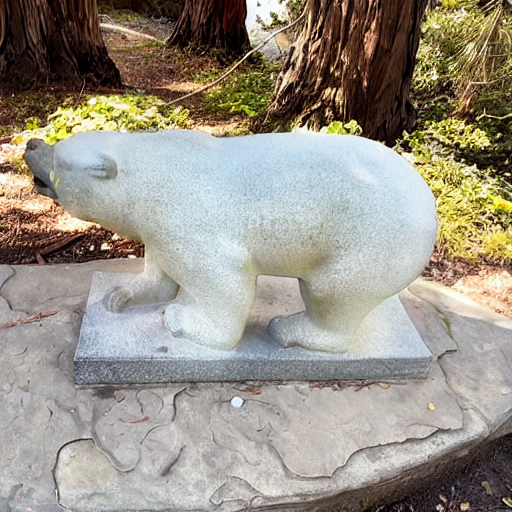

In [ ]:
path = "./bear/o/frame_00001.jpg"
image = load_512(path)
out_lf = image_optimization(pipeline, image,num_iters=200,text_source= "a photo of a gray bear statue standing on a rock, in a green forest with brown dirt on the ground.", text_target="a photo of a polar bear statue standing on a rock, in a green forest with brown dirt on the ground.", use_dds=True)
